In [1]:
import torch
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(x_val.shape)

(15407, 60, 9)
(2202, 60, 9)


(15407, 60, 9) (4403, 60, 9) (2202, 60, 9)


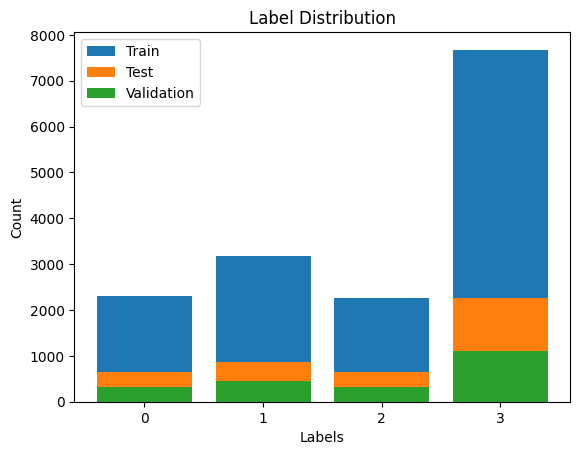

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_type, dataset_ver):
        self.X = np.array(np.load(f'Generated_Datasets/{dataset_type}_data_{dataset_ver}.npy'))
        self.y = np.array(np.load(f'Generated_Datasets/{dataset_type}_labels_{dataset_ver}.npy'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(np.asarray(self.y[idx])).float()
        return X, y

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
# Unidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.output = nn.Linear(self.hidden_size*2, output_size)

    def forward(self, x):
        # x = x.repeat(60, 1, 1)
        # x = x.reshape(x.shape[1], 60, self.hidden_size)
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
autoencoder = Autoencoder(n_input, n_hidden).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 720, batch_first=True)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)


In [8]:
# Bidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
# Bidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        # Concatenate Forward + Backward Pass - (seq_len, batch, num_directions * hidden_size)  
        encoded_x = (encoded_x[0, :, :] + encoded_x[1, :, :])
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
### Train AutoEncoder ###
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

def train_model(encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate=1e-3):
    
    # tensorboard logging
    writer = SummaryWriter(log_dir=f"tensorboard/{tag}")
    
    ### define model + optimizer ###
    autoencoder = Autoencoder(n_input, n_hidden, dropout_rate).to(device)
    print(autoencoder)
    optimizer = optim.Adam(autoencoder.parameters(),
                            lr=lr_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)
    optimizer.zero_grad()
    # early stopping (if applicable)
    early_stopper = EarlyStopper(patience=1, min_delta=10)

    best_loss = np.inf
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Starting Epoch {epoch+1}...')
        
        autoencoder.train()
        for X_batch, _ in tqdm(train_dataloader):
            X = X_batch.to(device)

            pred = autoencoder(X)
            train_loss = autoencoder.loss(pred, X)

            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(train_loss.item())
        
        autoencoder.eval()
        val_loss = 0.0
        for X_batch, _ in tqdm(val_dataloader):
            X = X_batch.to(device)

            pred = autoencoder(X)
            val_loss += autoencoder.loss(pred, X).item() * X_batch.size(0)        

        val_losses.append(val_loss / len(val_dataset))

        print(f'Epoch [{epoch+1}/{num_epochs}]\nTraining Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
        writer.add_scalars("Loss", {"train": train_losses[-1], 
                                    "val": val_losses[-1]}, epoch)

        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]

            # Save Encoder
            torch.save(autoencoder.encoder, f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_encoder.pt')
            # Save Full Autoencoder
            torch.save(autoencoder, f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_Autoencoder.pt')
        
        if early_stop and early_stopper.early_stop(val_losses[-1]):
            print("Early Stopping...")             
            break

    writer.close()
    return train_losses, val_losses

# train_losses, val_losses = train_model("bi_lstm_run_2", early_stop=True, dropout_rate=0.5, num_epochs=50, lr_rate=1e-3)


In [11]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard
# %reload_ext tensorboard
!taskkill /F /IM tensorboard.exe

ERROR: The process "tensorboard.exe" not found.


In [10]:
def plot_loss_graph(train_losses, val_losses, tag):
    plt.plot(range(len(train_losses)), train_losses, label= 'Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss across Epochs')
    plt.legend()
    plt.savefig(f'images/loss_{tag}.png')
    plt.show()

    # log these losses separately
    with open(f"logs/losses_{tag}.txt", "a") as file:
        file.write(f"---- Model: {tag} ----\n")
        file.write("Train Losses:\n")
        for epoch, loss in enumerate(train_losses, start=1):
            file.write(f"Epoch {epoch}: {loss}\n")
        file.write("Validation Losses:\n")
        for epoch, loss in enumerate(val_losses, start=1):
            file.write(f"Epoch {epoch}: {loss}\n")
        file.write("\n")

# plot_loss_graph(train_losses, val_losses, "bi_lstm_run_2")

In [11]:
### Encode Data ###
def encode_data(tag, encoder_ver):

    train_dataset = CustomDataset("train", dataset_ver)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    print('Loading Encoder Model...')
    encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_encoder.pt').to(device)
    encoder.eval()

    encoded_data = []
    labels = []

    print('Encoding Data...')
    with torch.no_grad():
        for batch in tqdm(train_dataloader):
            X_batch, y_batch = batch
            X = X_batch.to(device)
            y = y_batch.to(device).reshape(-1, 1)

            encoded_batch = encoder(X)
            # print(encoded_batch.shape)

            ### for unidirectional LSTM ###
            # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])

            ### bidirectional LSTM have hidden states in 2 dimensions ###
            # h_1, h_2 = encoded_batch[0], encoded_batch[1]
            # encoded_batch = torch.cat((h_1, h_2), 1)
            
            encoded_data.append(encoded_batch)
            labels.append(y)

        encoded_data = torch.cat(encoded_data, 0).cpu()
        labels = torch.cat(labels, 0).cpu()       

    print(f'{encoded_data.shape=}')
    print(f'{labels.shape=}')
    
    return encoded_data, labels

# encoded_data, labels = encode_data("bi_lstm_run_2", "360h50e0.5dr0.001lr")

In [12]:
### Train SVM ###
def train_svm(train_data, train_labels, tag, encoder_ver):
    print("Training SVM Classifier...")
    x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=0)
    svm_classifier = svm.SVC(kernel='rbf', probability=True)
    svm_classifier.fit(x_train, y_train)

    test_pred = svm_classifier.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, test_pred)}')

    # Save SVM Classifier
    with open(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_svm_classifier.pkl', "wb") as file:
        pickle.dump(svm_classifier, file)

    return svm_classifier

# svm_classifier = train_svm(encoded_data, labels.ravel())

In [19]:
### Test SVM + Encoder ###
def test_model(tag, encoder_ver):
    test_dataset = CustomDataset("test", dataset_ver)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    # Load the saved models
    encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_Autoencoder.pt')
    encoder.eval()
    with open(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_svm_classifier.pkl', 'rb') as file:
        svm_classifier = pickle.load(file)

    test_encoded_data = []
    test_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            X_batch, y_batch = batch
            X = X_batch.to(device)
            y = y_batch.to(device).reshape(-1, 1)

            test_encoded_batch = encoder.encoder(X)
            # print(encoded_batch.shape)
            
            ### for unidirectional LSTM ###
            # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])
            
            ### bidirectional LSTM have hidden states in 2 dimensions ###
            # h_1, h_2 = encoded_batch[0], encoded_batch[1]
            # encoded_batch = torch.cat((h_1, h_2), 1)
            
            test_encoded_data.append(test_encoded_batch)
            test_labels.append(y)

        test_encoded_data = torch.cat(test_encoded_data, 0).cpu()
        test_labels = torch.cat(test_labels, 0).cpu()   

    print(f'{test_encoded_data.shape=}')
    print(f'{test_labels.shape=}')

    test_predictions = svm_classifier.predict(test_encoded_data)
    print(f'{test_predictions.shape=}')
    return test_labels, test_predictions

In [20]:
def calculate_accuracy(test_labels, test_predictions, tag):
    # Calculate accuracy score
    accuracy = accuracy_score(test_labels, test_predictions)
    accuracy_percentage = accuracy * 100
    print(f"Accuracy: {accuracy_percentage:.2f}%")
    with open(f"logs/losses_{tag}.txt", "a") as file:
        file.write(f"SVM Test Accuracy: {accuracy_percentage:.2f}%\n")


    # Create a confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues')

    # Add labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'images/cm_{tag}.png')
    plt.show()

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0234, Val Loss: 0.0219
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0109, Val Loss: 0.0105
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0076, Val Loss: 0.0072
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0048, Val Loss: 0.0063
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0048, Val Loss: 0.0054
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0053, Val Loss: 0.0048
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0035, Val Loss: 0.0047
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0044, Val Loss: 0.0043
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0025, Val Loss: 0.0036
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0039, Val Loss: 0.0034
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0032, Val Loss: 0.0033
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0034, Val Loss: 0.0031
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0035, Val Loss: 0.0030
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0037, Val Loss: 0.0029
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0029, Val Loss: 0.0029
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0031, Val Loss: 0.0027
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0027, Val Loss: 0.0026
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0027, Val Loss: 0.0025
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0028, Val Loss: 0.0025
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0028, Val Loss: 0.0023
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0023, Val Loss: 0.0023
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0017, Val Loss: 0.0023
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0027, Val Loss: 0.0021
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0021, Val Loss: 0.0021
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0022, Val Loss: 0.0020
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0014, Val Loss: 0.0019
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0021, Val Loss: 0.0020
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0018, Val Loss: 0.0020
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0014, Val Loss: 0.0018
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0012, Val Loss: 0.0019
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0019, Val Loss: 0.0019
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0018, Val Loss: 0.0018
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0022, Val Loss: 0.0019
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0017, Val Loss: 0.0018
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0026, Val Loss: 0.0017
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0013, Val Loss: 0.0017
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0013, Val Loss: 0.0017
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0017, Val Loss: 0.0017
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0015, Val Loss: 0.0017
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0015, Val Loss: 0.0017
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0017, Val Loss: 0.0017
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0026, Val Loss: 0.0016
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0011, Val Loss: 0.0016
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0017, Val Loss: 0.0016
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0015, Val Loss: 0.0016
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0018, Val Loss: 0.0016
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0018, Val Loss: 0.0016
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0019, Val Loss: 0.0016
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0016, Val Loss: 0.0015
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0010, Val Loss: 0.0015


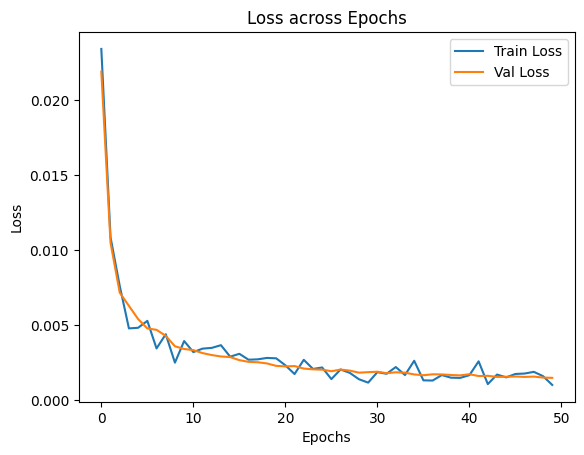

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9266709928617781


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 93.23%


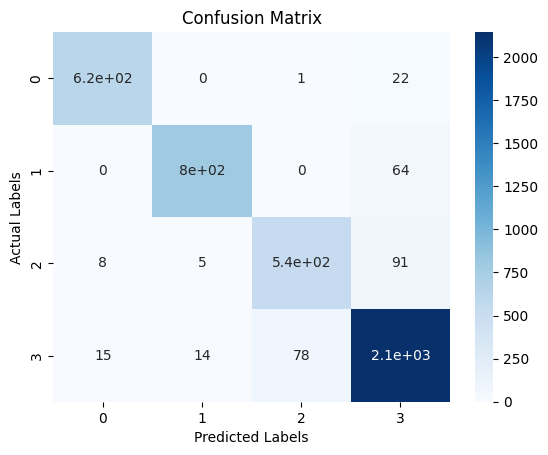

In [22]:
### Hyperparameters ###
tag = "bi_lstm_run_4"
early_stop = True
dropout_rate=0.2
num_epochs=50
lr_rate=1e-3

### Streamlined training of model + SVM ###
encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
train_losses, val_losses = train_model(encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
plot_loss_graph(train_losses, val_losses, tag)
encoded_data, labels = encode_data(tag, encoder_ver)
svm_classifier = train_svm(encoded_data, labels.ravel(), tag, encoder_ver)
### Streamlined testing of model + SVM ###
test_labels, test_predictions = test_model(tag, encoder_ver)
calculate_accuracy(test_labels, test_predictions, tag)